# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import re, pickle
import matplotlib.pyplot as plt

# for NLP tasks
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

# for modeling tasks
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

# NLP data augmentation
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet')

# for long calculations
import winsound
def make_sound():
    frequency = 440  # Set Frequency To 2500 Hertz
    duration = 1000  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lveys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lveys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lveys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table(table_name='messages', con=engine)
X = df.select_dtypes(include=['object']).drop('original',axis=1)
# There are 36 classes
Y = df.select_dtypes(include=['int64'])

In [3]:
print(f'X has rows x columns = {X.shape}')
print(f'Y has rows x columns = {Y.shape}')

X has rows x columns = (26215, 2)
Y has rows x columns = (26215, 36)


<AxesSubplot:>

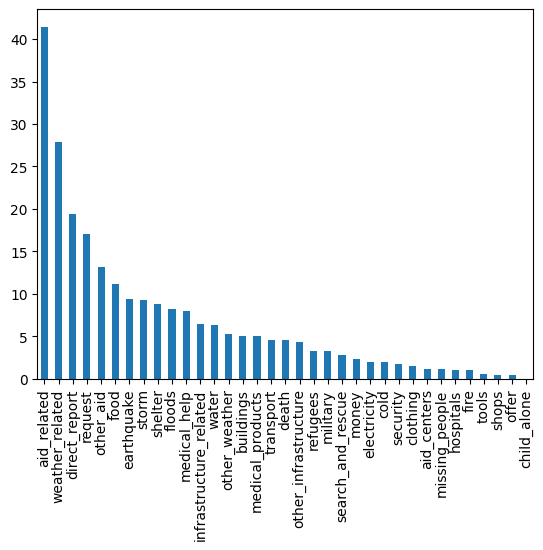

In [22]:
# Reminder : highly imbalanced 36 class representation - 1 class over 40%, 4 classes over 95%
(Y.iloc[:,1:].sum(axis=0).sort_values(ascending=False)/len(Y)*100).plot(kind='bar')

In [4]:
X.genre.unique()

array(['direct', 'social', 'news'], dtype=object)

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    # Todo: normalize case and remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

    # Todo: tokenize text
    tokens = word_tokenize(text)
    
    # Todo: lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token,pos='v') for token in tokens]
    
    return tokens

In [6]:
# CHECK
print(X.message[2])
tokenize(X.message[2])

Looking for someone but no name


['look', 'someone', 'name']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [84]:
pipeline_baseline = Pipeline([   ('tokenization', CountVectorizer(tokenizer=tokenize, min_df=3, max_features=10000)),
                        ('vectorization',TfidfTransformer()),
                        ('modelisation', MultiOutputClassifier(estimator=RandomForestClassifier(), n_jobs=-1))  
                    ])

In [85]:
pipeline = Pipeline([   ('tokenization', CountVectorizer(tokenizer=tokenize, min_df=3, max_features=10000)),
                        ('vectorization',TfidfTransformer()),
                        ('modelisation', MultiOutputClassifier(estimator=XGBClassifier(), n_jobs=-1)) 
                    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [86]:
# Select message feature, drop the rest
Xtrain,Xtest,ytrain,ytest = train_test_split(X.message,Y, random_state=10, test_size=0.2)   # stratify ??
pipeline_baseline.fit(Xtrain, ytrain)
make_sound()

In [87]:
pipeline.fit(Xtrain, ytrain)
make_sound()

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [116]:
def model_performance(pipeline, x,y, name):    
    yhat = pipeline.predict(x)
    labels = y.columns.tolist()
    micro_score=[]
    for i in range(len(labels)):
        print(f'******************************** {labels[i]} *******************************')
        cr = classification_report(y.iloc[:,i], yhat[:,i], zero_division=0)
        micro_score.append(round(f1_score(y.iloc[:,i], yhat[:,i],average='macro'),2))
        print(cr)  #, labels=labels
        print()
    perf = pd.DataFrame(micro_score, index=labels, columns=[name])
    return perf

def plot_performance(performance_df):
    performance_df.plot(kind='bar', figsize=(20,5))
    plt.title('Macro (unweighted) F1 score across classification labels')
    plt.tight_layout()
    plt.show()

******************************** related *******************************
              precision    recall  f1-score   support

           0       0.72      0.42      0.53      1255
           1       0.84      0.95      0.89      3944
           2       0.51      0.50      0.51        44

    accuracy                           0.82      5243
   macro avg       0.69      0.62      0.64      5243
weighted avg       0.80      0.82      0.80      5243


******************************** request *******************************
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4349
           1       0.82      0.47      0.60       894

    accuracy                           0.89      5243
   macro avg       0.86      0.73      0.77      5243
weighted avg       0.89      0.89      0.88      5243


******************************** offer *******************************
              precision    recall  f1-score   support

           0      

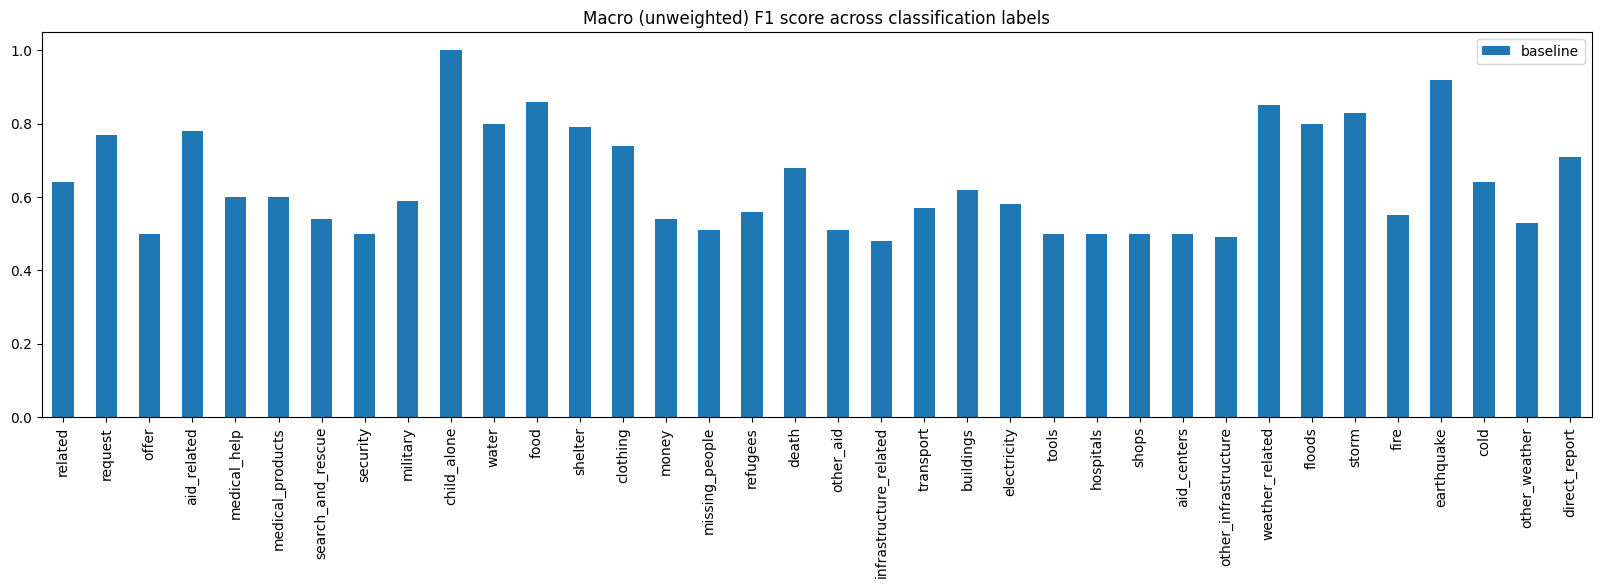

In [92]:
performance_df = pd.DataFrame()
perf = model_performance(pipeline_baseline, Xtest, ytest, 'baseline')
performance_df = pd.concat([performance_df, perf], axis=1)
plot_performance(performance_df)

******************************** related *******************************
              precision    recall  f1-score   support

           0       0.72      0.36      0.48      1255
           1       0.82      0.96      0.88      3944
           2       0.50      0.11      0.19        44

    accuracy                           0.81      5243
   macro avg       0.68      0.48      0.52      5243
weighted avg       0.79      0.81      0.78      5243


******************************** request *******************************
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4349
           1       0.80      0.54      0.65       894

    accuracy                           0.90      5243
   macro avg       0.86      0.76      0.79      5243
weighted avg       0.89      0.90      0.89      5243


******************************** offer *******************************
              precision    recall  f1-score   support

           0      

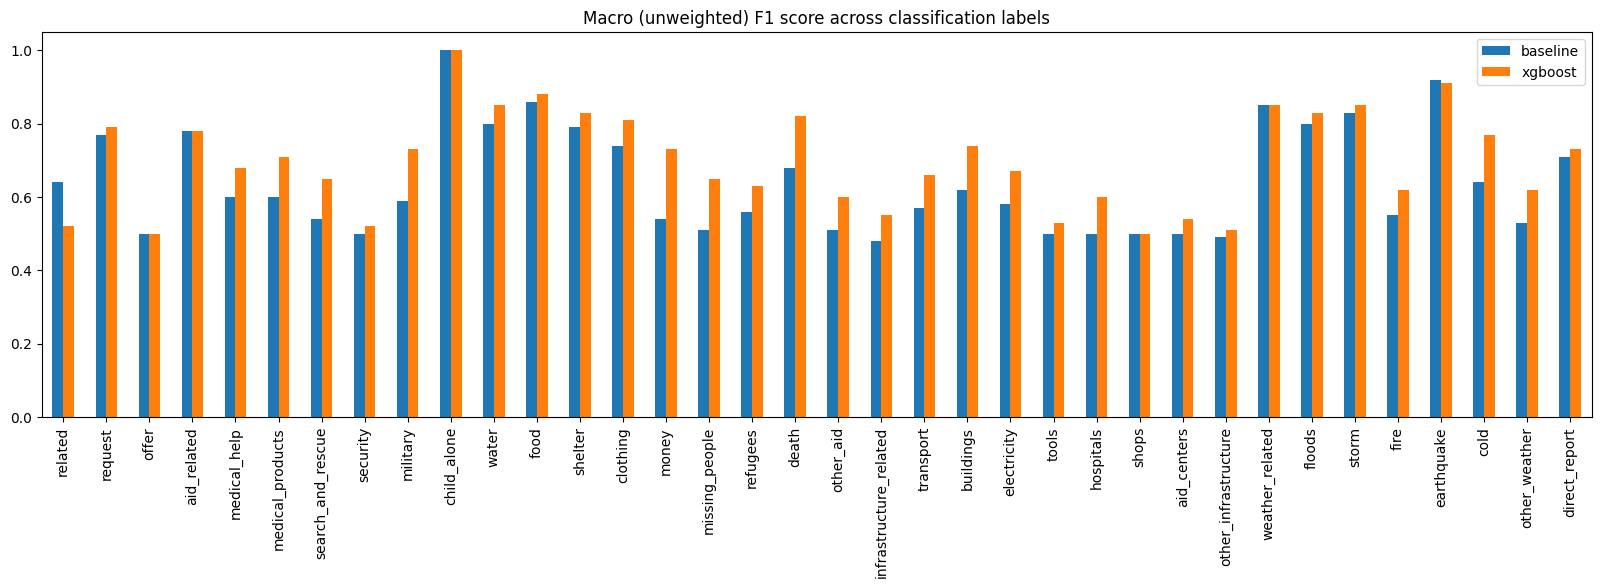

In [93]:
perf = model_performance(pipeline, Xtest, ytest, 'xgboost')
performance_df = pd.concat([performance_df, perf], axis=1)
plot_performance(performance_df)

### 6. Improve your model
Use grid search to find better parameters. 

In [66]:
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('tokenization',
                 CountVectorizer(max_features=10000, min_df=3,
                                 tokenizer=<function tokenize at 0x000001B16BABB820>)),
                ('vectorization', TfidfTransformer()),
                ('modelisation',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stoppin...
                                                               grow_policy=None,
                                   

In [59]:
pipeline['tokenization'].get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 10000,
 'min_df': 3,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenize(text)>,
 'vocabulary': None}

In [48]:
len(pipeline['tokenization'].vocabulary_)

8198

In [49]:
pipeline['tokenization'].vocabulary_

{'response': 6234,
 'combination': 1645,
 'grind': 3327,
 'aerial': 482,
 'attack': 831,
 'urge': 7779,
 'local': 4409,
 'set': 6599,
 'aside': 789,
 'vote': 7919,
 'candidate': 1325,
 'serve': 6596,
 'interest': 3911,
 'region': 6099,
 'country': 1904,
 'whole': 8038,
 'upcoming': 7759,
 'general': 3174,
 'election': 2551,
 'thus': 7392,
 'arm': 758,
 'drone': 2438,
 'strike': 7033,
 'pakistan': 5357,
 'nigerian': 5053,
 'army': 761,
 'massacre': 4591,
 'villager': 7882,
 'plan': 5586,
 'new': 5029,
 'u': 7630,
 'base': 965,
 'niger': 5051,
 'joint': 4065,
 'israeli': 3989,
 'military': 4734,
 'operation': 5222,
 'see': 6535,
 'part': 5398,
 'wider': 8046,
 'pattern': 5447,
 'western': 8020,
 'persistently': 5508,
 'spread': 6932,
 'social': 6812,
 'medium': 4646,
 'want': 7947,
 'know': 4188,
 'many': 4557,
 'death': 2072,
 'wound': 8114,
 'due': 2452,
 'quake': 5916,
 'fao': 2856,
 'look': 4432,
 'availability': 862,
 'short': 6674,
 'mature': 4606,
 'rice': 6275,
 '50': 254,
 'part

In [67]:
pipeline['modelisation'].get_params()

{'estimator__objective': 'binary:logistic',
 'estimator__use_label_encoder': None,
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_estimators': 100,
 'esti

In [68]:
pipeline['modelisation'].get_params()['estimator'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [80]:
 # specify parameters for grid search
parameters = { #'tokenization__ngram_range':[(1,1),(1,2)],
                #'vectorization__use_idf':[True, False],
                #'vectorization__sublinear_tf':[True,False],
                'modelisation__estimator__n_estimators':[150,200,500],
                'modelisation__estimator__max_depth':[5,7,10],
                
}

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=3, n_jobs=8, cv=2)
Xtrain,Xtest,ytrain,ytest = train_test_split(X.message,Y, random_state=10, test_size=0.2)   # stratify ??
cv.fit(Xtrain,ytrain)
print('BEST PARAMS:',cv.best_params_)
make_sound()

Fitting 2 folds for each of 9 candidates, totalling 18 fits
BEST PARAMS: {'modelisation__estimator__max_depth': 7, 'modelisation__estimator__n_estimators': 200}


In [54]:
cv.best_estimator_

Pipeline(steps=[('tokenization',
                 CountVectorizer(max_features=10000, min_df=3,
                                 tokenizer=<function tokenize at 0x000001B16BABB820>)),
                ('vectorization', TfidfTransformer()),
                ('modelisation',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10),
                                       n_jobs=-1))])

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

******************************** related *******************************
              precision    recall  f1-score   support

           0       0.71      0.47      0.56      1255
           1       0.84      0.94      0.89      3944
           2       0.50      0.14      0.21        44

    accuracy                           0.82      5243
   macro avg       0.68      0.51      0.55      5243
weighted avg       0.81      0.82      0.80      5243


******************************** request *******************************
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4349
           1       0.79      0.57      0.66       894

    accuracy                           0.90      5243
   macro avg       0.85      0.77      0.80      5243
weighted avg       0.89      0.90      0.89      5243


******************************** offer *******************************
              precision    recall  f1-score   support

           0      

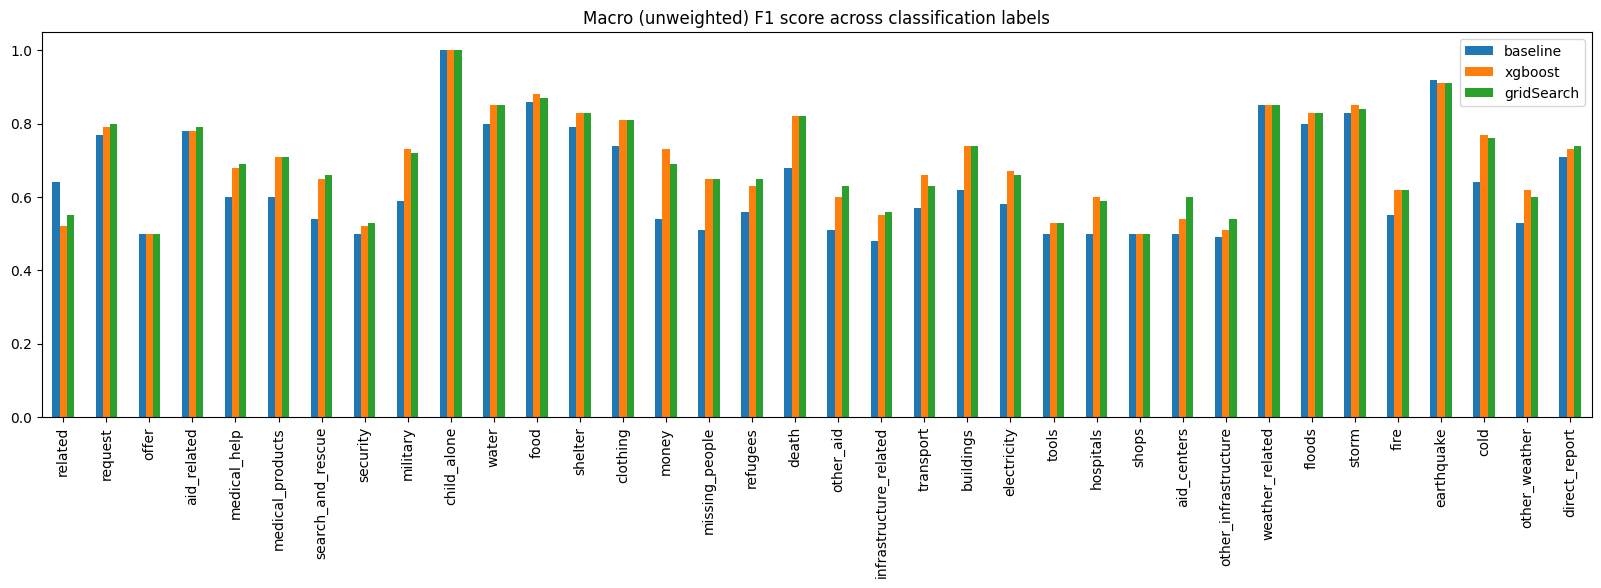

In [94]:
perf = model_performance(cv.best_estimator_, Xtest, ytest, 'gridSearch')
performance_df = pd.concat([performance_df, perf], axis=1)
plot_performance(performance_df)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

## a. Use `genre` categorical feature

In [95]:
genre_dummies = pd.get_dummies(X.genre)

In [96]:
X_extended = pd.concat([X.drop('genre', axis=1), genre_dummies], axis=1)
X_extended

,message,direct,news,social
0,Weather update - a cold front from Cuba that c...,1,0,0
1,Is the Hurricane over or is it not over,1,0,0
2,Looking for someone but no name,1,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,1,0,0
4,"says: west side of Haiti, rest of the country ...",1,0,0
...,...,...,...,...
26210,The training demonstrated how to enhance micro...,0,1,0
26211,A suitable candidate has been selected and OCH...,0,1,0
26212,"Proshika, operating in Cox's Bazar municipalit...",0,1,0
26213,"Some 2,000 women protesting against the conduc...",0,1,0


In [97]:
text_transform = Pipeline([ ('tokenization', CountVectorizer(tokenizer=tokenize, min_df=3, max_features=10000)),
                            ('vectorization', TfidfTransformer()),
                        ])

# Build a Column transformer
preprocessing = ColumnTransformer(
                                    transformers=[
                                                    ("text_transform", text_transform, 'message'),                  
                                                ],
                                    remainder='passthrough'  # passthrough any columns which did not receive a transformation
                                )
# Build pipeline
pipeline2 = Pipeline([ ('preprocessing',preprocessing),
                      ('modelisation', MultiOutputClassifier(estimator=XGBClassifier(), n_jobs=-1))
                ])

In [98]:
Xext_train,Xext_test,yext_train,yext_test = train_test_split(X_extended,Y, random_state=10, test_size=0.2)   # stratify ??
pipeline2.fit(Xext_train, yext_train)
make_sound()

c:\Users\lveys\anaconda3\envs\xgboost_py38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


******************************** related *******************************
              precision    recall  f1-score   support

           0       0.70      0.47      0.57      1255
           1       0.85      0.94      0.89      3944
           2       0.55      0.14      0.22        44

    accuracy                           0.82      5243
   macro avg       0.70      0.52      0.56      5243
weighted avg       0.81      0.82      0.81      5243


******************************** request *******************************
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4349
           1       0.80      0.57      0.66       894

    accuracy                           0.90      5243
   macro avg       0.86      0.77      0.80      5243
weighted avg       0.90      0.90      0.90      5243


******************************** offer *******************************
              precision    recall  f1-score   support

           0      

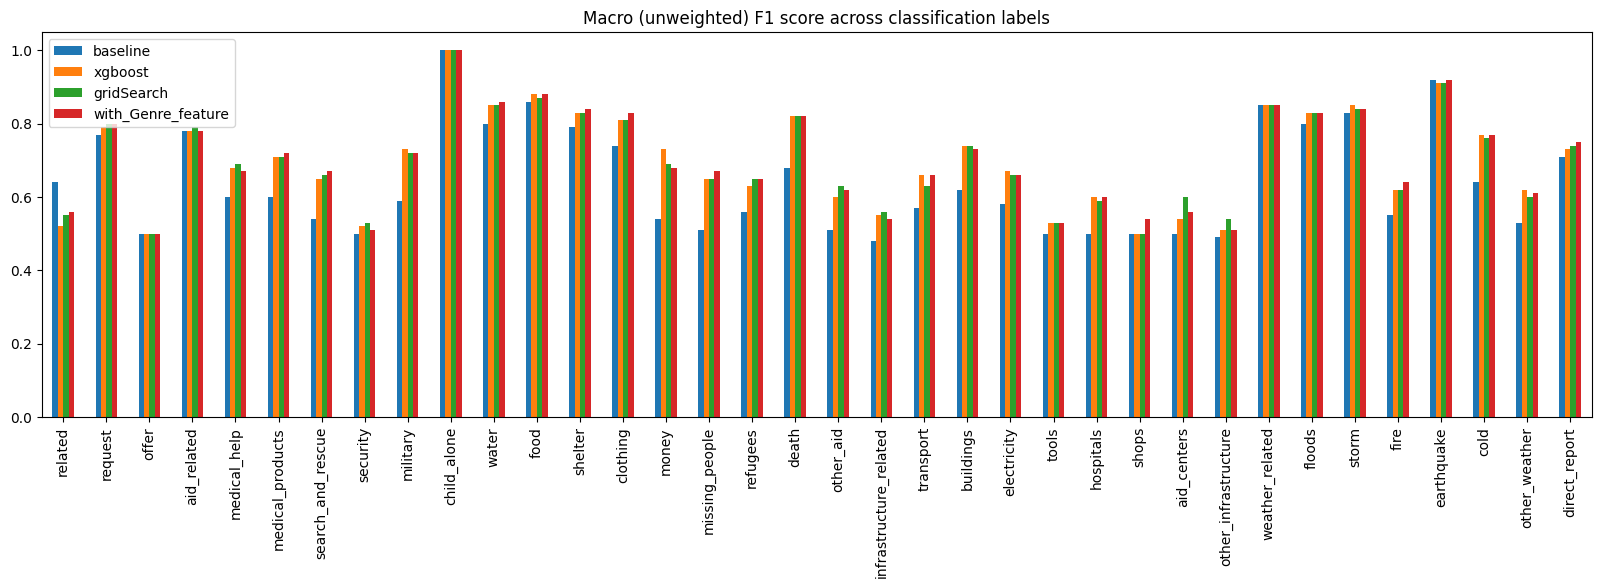

In [99]:
perf = model_performance(pipeline2, Xext_test, yext_test, 'with_Genre_feature')
performance_df = pd.concat([performance_df, perf], axis=1)
plot_performance(performance_df)

## b. Data augmentation with NLPAug
- https://towardsdatascience.com/data-augmentation-library-for-text-9661736b13ff
- https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb
- https://nlpaug.readthedocs.io/en/latest/index.html

In [100]:
labels = df.columns[3:]
sorted_labels = df[labels].sum(axis=0).sort_values().index
df[labels].sum(axis=0).sort_values()

child_alone                   0
offer                       118
shops                       120
tools                       159
fire                        282
hospitals                   283
missing_people              298
aid_centers                 309
clothing                    405
security                    471
cold                        530
electricity                 532
money                       604
search_and_rescue           724
military                    860
refugees                    875
other_infrastructure       1151
death                      1194
transport                  1201
medical_products           1313
buildings                  1333
other_weather              1376
water                      1672
infrastructure_related     1705
medical_help               2084
floods                     2155
shelter                    2314
storm                      2443
earthquake                 2455
food                       2923
other_aid                  3446
request 

In [101]:
under_represented_labels = sorted_labels[df[labels].sum(axis=0).sort_values()<1000]
df[under_represented_labels].sum(axis=1)==1

0        False
1        False
2        False
3         True
4        False
         ...  
26210    False
26211    False
26212    False
26213     True
26214    False
Length: 26215, dtype: bool

In [102]:
df.loc[df[under_represented_labels].sum(axis=1)==1,:]

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
3,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
15,"A Comitee in Delmas 19, Rue ( street ) Janvier...",Komite katye delma 19 rue janvier imp charite ...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
49,People from Jacmel are requesting a tractor in...,MOUN JACMEL YO MANDE POU ENSTANS KONSENE YO VO...,direct,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,"For your information, There are people that ar...",Pou infomasyon juska pwesent genyen moun yo to...,direct,1,1,0,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
59,"SOS SOS, please provide police officers on the...",EMGENCY EMGENCY SI POLIS LA TE KA BAY PREZANS ...,direct,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26193,The tendency to link deforestation with large ...,None,news,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,0
26202,"BANGKOK, 24 January 2012 (NNT) - Prime Ministe...",None,news,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
26204,Epidemic surveillance: National Institute of C...,None,news,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
26205,2.1 Due to sporadic skirmishes in eastern D.R....,None,news,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
msg_to_augment = df.loc[df[under_represented_labels].sum(axis=1)==1,:].message
msg_to_augment

3        UN reports Leogane 80-90 destroyed. Only Hospi...
15       A Comitee in Delmas 19, Rue ( street ) Janvier...
49       People from Jacmel are requesting a tractor in...
56       For your information, There are people that ar...
59       SOS SOS, please provide police officers on the...
                               ...                        
26193    The tendency to link deforestation with large ...
26202    BANGKOK, 24 January 2012 (NNT) - Prime Ministe...
26204    Epidemic surveillance: National Institute of C...
26205    2.1 Due to sporadic skirmishes in eastern D.R....
26213    Some 2,000 women protesting against the conduc...
Name: message, Length: 3535, dtype: object

In [104]:
sample = msg_to_augment[3]
sample

'UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.'

In [105]:
augmented_text = aug.augment(sample)
print("Original:")
print(sample)
print("Augmented Text:")
print(augmented_text[0])

Original:
UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
Augmented Text:
UN reports Leogane 80 - 90 destroyed. Exclusively Infirmary St. Croix functioning. Pauperism supplying urgently.


In [106]:
list_rows = []
df_to_augment = df.loc[df[under_represented_labels].sum(axis=1)==1,:]
for idx, row in df_to_augment.iterrows():
    sample = row['message']
    augmented_text = aug.augment(sample)
    new_row = row.copy()
    new_row['message'] = augmented_text[0]
    list_rows.append(new_row)
    
augmented_df = pd.DataFrame(list_rows)
augmented_df = pd.concat([df, augmented_df], axis=0)
augmented_df.reset_index(drop=True, inplace=True)
augmented_df

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29745,The tendency to link disforestation with magna...,None,news,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,0
29746,"BANGKOK, 24 January 2012 (NNT) - Blossom Minis...",None,news,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
29747,Epidemic surveillance: National Institute of C...,None,news,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
29748,2. 1 Referable to sporadic skirmishes in easte...,None,news,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
augmented_df[labels].sum(axis=0).sort_values()

child_alone                   0
shops                       161
offer                       195
tools                       212
missing_people              396
hospitals                   411
aid_centers                 430
fire                        431
security                    627
clothing                    666
cold                        828
electricity                 876
money                      1046
search_and_rescue          1060
refugees                   1363
military                   1403
other_infrastructure       1486
transport                  1508
death                      1517
medical_products           1662
buildings                  1687
other_weather              1710
water                      1966
infrastructure_related     2291
medical_help               2518
floods                     2635
earthquake                 2857
shelter                    2914
storm                      2938
food                       3487
other_aid                  4302
request 

In [108]:
X_aug = augmented_df.select_dtypes(include=['object']).drop('original',axis=1)
# There are 36 classes
Y_aug = augmented_df.select_dtypes(include=['int64'])

In [109]:
def train_model(pipeline, x, y):
    # TRAIN
    Xtrain,Xtest,ytrain,ytest = train_test_split(x.message,y, random_state=10, test_size=0.2)   # stratify ??
    pipeline.fit(Xtrain, ytrain)
    make_sound()

    return pipeline, Xtrain,Xtest,ytrain,ytest

In [111]:
pipeline1 = Pipeline([   ('tokenization', CountVectorizer(tokenizer=tokenize, min_df=3, max_features=10000)),
                        ('vectorization',TfidfTransformer()),
                        ('modelisation', MultiOutputClassifier(estimator=RandomForestClassifier(), n_jobs=-1))
                    ])

In [112]:
pipeline1, Xtrain,Xtest,ytrain,ytest = train_model(pipeline1, X_aug, Y_aug)  #, 'RF_augmented', performance_df

******************************** related *******************************
              precision    recall  f1-score   support

           0       0.71      0.42      0.53      1244
           1       0.86      0.95      0.90      4659
           2       0.54      0.45      0.49        47

    accuracy                           0.84      5950
   macro avg       0.70      0.61      0.64      5950
weighted avg       0.82      0.84      0.82      5950


******************************** request *******************************
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4885
           1       0.86      0.51      0.64      1065

    accuracy                           0.90      5950
   macro avg       0.88      0.74      0.79      5950
weighted avg       0.89      0.90      0.89      5950


******************************** offer *******************************
              precision    recall  f1-score   support

           0      

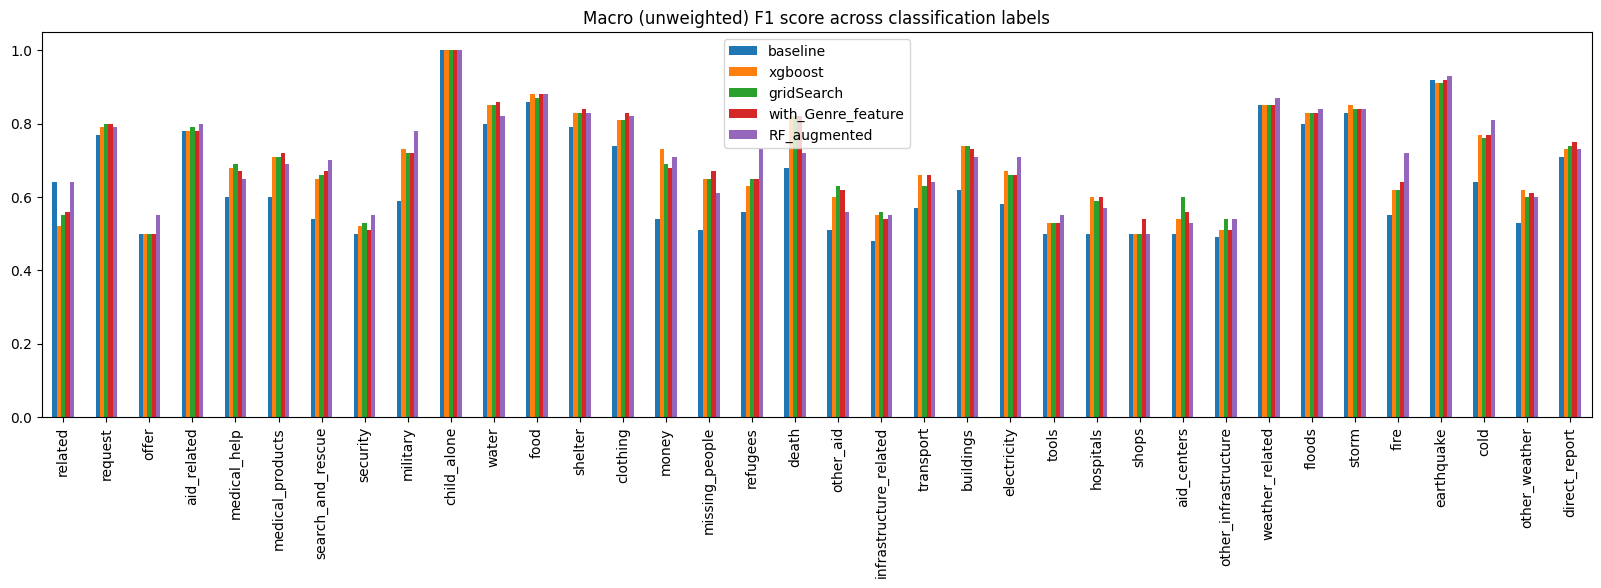

In [113]:
perf = model_performance(pipeline1, Xtest, ytest, 'RF_augmented')
performance_df = pd.concat([performance_df, perf], axis=1)
plot_performance(performance_df)

In [114]:
# XGBOOST with augmented dataset
pipeline3 = Pipeline([   ('tokenization', CountVectorizer(tokenizer=tokenize, min_df=3, max_features=10000)),
                        ('vectorization',TfidfTransformer()),
                        ('modelisation', MultiOutputClassifier(estimator=XGBClassifier(), n_jobs=-1))
                    ])

pipeline3, Xtrain,Xtest,ytrain,ytest = train_model(pipeline3, X_aug, Y_aug) 

******************************** related *******************************
              precision    recall  f1-score   support

           0       0.72      0.34      0.46      1244
           1       0.84      0.97      0.90      4659
           2       0.62      0.11      0.18        47

    accuracy                           0.83      5950
   macro avg       0.73      0.47      0.51      5950
weighted avg       0.81      0.83      0.80      5950


******************************** request *******************************
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4885
           1       0.82      0.54      0.65      1065

    accuracy                           0.90      5950
   macro avg       0.86      0.76      0.79      5950
weighted avg       0.89      0.90      0.89      5950


******************************** offer *******************************
              precision    recall  f1-score   support

           0      

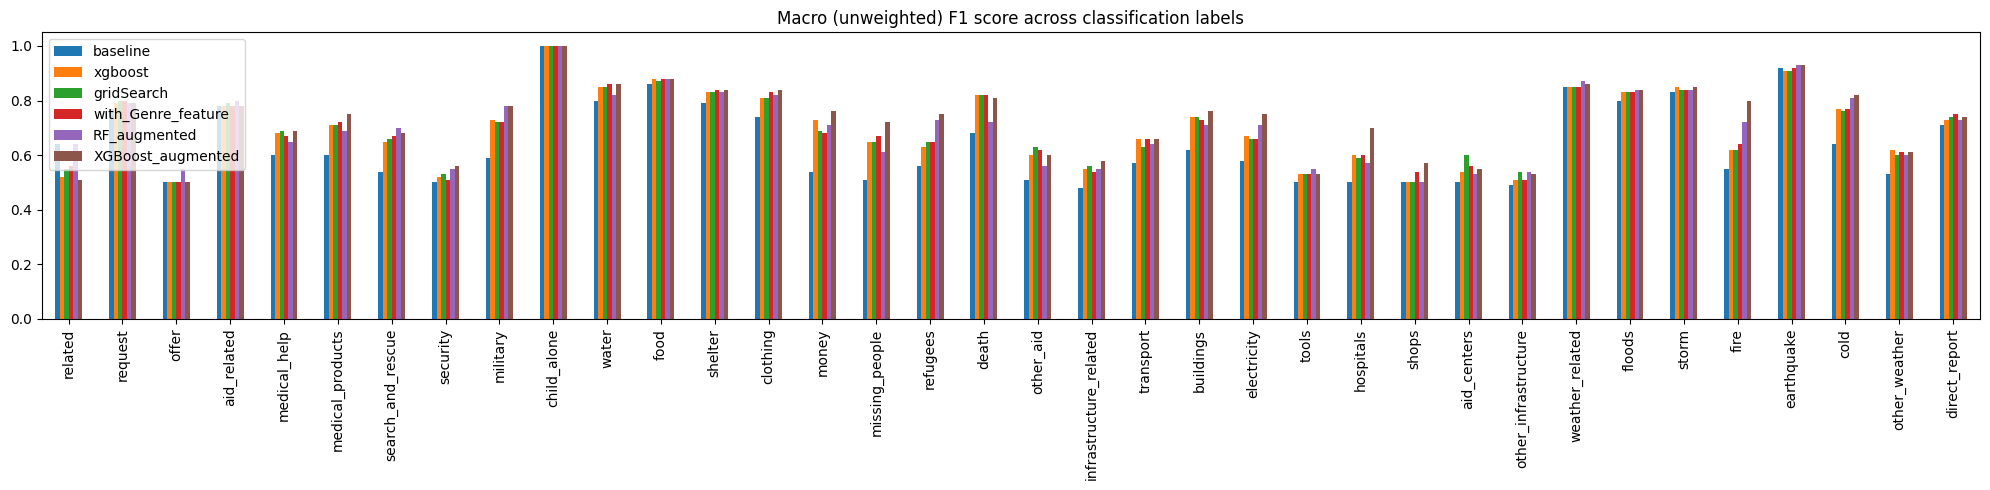

In [121]:
perf = model_performance(pipeline3, Xtest, ytest, 'XGBoost_augmented')
performance_df = pd.concat([performance_df, perf], axis=1)
plot_performance(performance_df)

### 9. Export your model as a pickle file

In [122]:
# save the model to disk
filename = './models/finalized_model.pk'
pickle.dump(pipeline3, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.